<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/FINAL_regression_and_kalman_regression_(delta_time_series)_without_removing_outliers_and_star_with_only_emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
#import functions.Kalman_filter as KF

In [ ]:
data = pd.read_excel('/content/MEF_2030.xlsx')
data.drop(data.loc[data['Date'].duplicated()].index, inplace = True)
#df['datetime'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])

data.set_index(data['Date'], inplace = True)
data.drop(columns = ['Date'], inplace = True)
data.tail()

,Emissions,Generation
Date,,
2030-12-31 19:00:00,164,2.741193e+07
2030-12-31 20:00:00,104,1.496632e+07
2030-12-31 21:00:00,144,3.134442e+07
2030-12-31 22:00:00,104,1.496632e+07
2030-12-31 23:00:00,71,1.302752e+07


**Data cleaning**
Data can contain NaNs, negative values, zeros and outliers. Let's have a look!

In [ ]:
from pandas.core.groupby.grouper import DataFrame
data[data.isna().any(axis=1)].tail()
data=DataFrame(data)

no missing values

In [ ]:
df = data[ ["Emissions","Generation"] ]

Data preprocessing

In [ ]:
import pandas as pd


# Step 1: Check for negative values in Generation and convert them to zero
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Step 2: Check for zero values in Generation and convert corresponding Emission values to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Step 3: Display the results
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero variables in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Step 4: Optionally, save the preprocessed data back to a new Excel file
#data.to_excel('Preprocessed_Data.xlsx', index=False)

Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero variables in Generation: 0
Number of Emissions converted to zero: 0


use delata gerneration and delta emission

In [ ]:
 #take first diff time series
ret = data-data.shift()[1:]
#eliminate this if not first diff time series
ret = ret[1:]
print(ret)

                     Emissions    Generation
Date                                        
2030-01-01 00:00:00        0.0  2.678619e+06
2030-01-01 01:00:00      -18.0 -3.684126e+06
2030-01-01 02:00:00      -24.0 -4.121123e+06
2030-01-01 03:00:00       19.0 -2.278624e+05
2030-01-01 04:00:00        0.0  1.339853e+06
...                        ...           ...
2030-12-31 19:00:00       60.0  1.244561e+07
2030-12-31 20:00:00      -60.0 -1.244561e+07
2030-12-31 21:00:00       40.0  1.637810e+07
2030-12-31 22:00:00      -40.0 -1.637810e+07
2030-12-31 23:00:00      -33.0 -1.938805e+06

[8759 rows x 2 columns]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ret["Generation"] = scaler.fit_transform(ret[["Generation"]])
ret["Emissions"] = scaler.fit_transform(ret[["Emissions"]])
#ret["CO2"] = scaler.fit_transform(ret[["CO2"]])
print(ret)

                     Emissions  Generation
Date                                      
2030-01-01 00:00:00   0.000319    0.858300
2030-01-01 01:00:00  -0.811119   -1.180099
2030-01-01 02:00:00  -1.081599   -1.320098
2030-01-01 03:00:00   0.856837   -0.072834
2030-01-01 04:00:00   0.000319    0.429407
...                        ...         ...
2030-12-31 19:00:00   2.705113    3.987300
2030-12-31 20:00:00  -2.704475   -3.986970
2030-12-31 21:00:00   1.803515    5.247131
2030-12-31 22:00:00  -1.802877   -5.246801
2030-12-31 23:00:00  -1.487318   -0.620960

[8759 rows x 2 columns]


Check again if there is missing values

In [ ]:
import pandas as pd

# Assuming you have your data loaded into a DataFrame called 'ret'

# Find rows with missing values
missing_rows = ret[ret.isna().any(axis=1)].tail()

# Get the column names with missing values
cols_with_missing = ret.columns[ret.isna().any()].tolist()

# Prepare text results
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = "Rows with missing values:\n" + missing_rows.to_string(index=False)

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)


No rows with missing values found.

No columns with missing values.


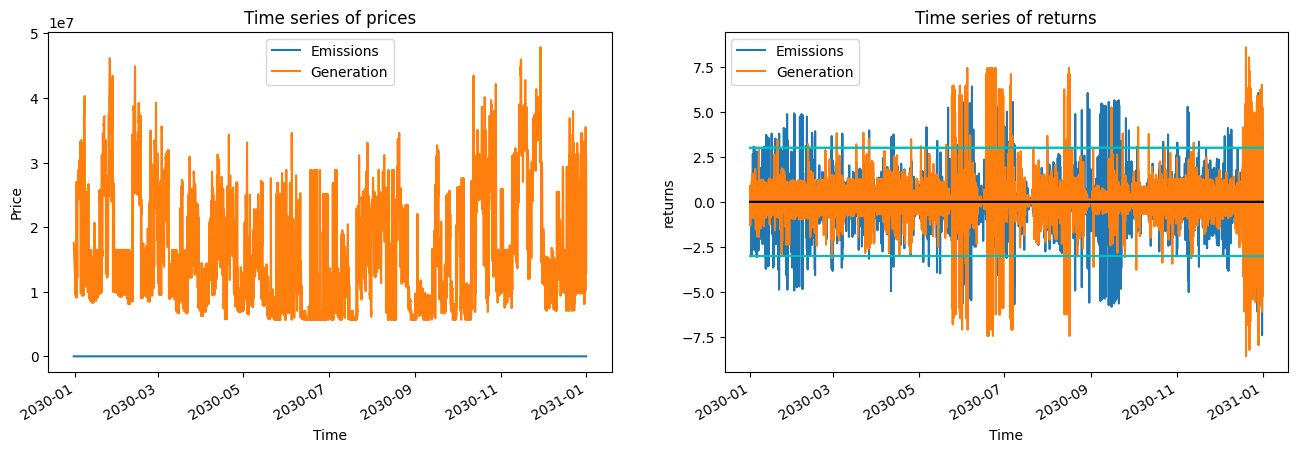

In [ ]:

NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel("returns")
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='c' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='c' )
plt.show()

# **What about the outliers?**

**What about the outliers?**


We can see that there are returns that are quite bigger than 3σ (three standard deviations).
If we assume a Normal distribution for the returns, these outliers can create problems.

Wait a second...
we calculated the standard deviation ret.std() using the data containing the ouliers!!
It means that the value of the standard deviation is aslo affected by the outliers!!

The solution is to use robust estimators of the location and the dispersion of a distribution. They work much better in presence of outliers.

Although there are several alternatives, I prefer to use the median and the MAD. These estimators are more robust than the mean and standard deviation. In the standard deviation, the distances from the mean are squared, so large deviations are weighted more heavily, and thus outliers can heavily influence it. In the MAD instead, the deviations of a small number of outliers are irrelevant.

As explained on wiki, in order to use the MAD as a consistent estimator of the standard deviation, we have to take

σ
=
k
MAD
where under the assumption of Normal distribution,
k
=
1.4826
.



In [ ]:
#median = ret.median()
#MAD = ret.mad()

#sig_robust = MAD*1.4826
#print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust);

In [ ]:
##outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
#dret = ret.drop(outliers.index)                                           # series of returns without outliers

In [ ]:
#fig = plt.figure(figsize=(16,6))
#ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

#for ax, col in zip([ax1,ax2], dret.columns):
 #   dret[col].plot(ax=ax)
  #  ax.set_title("Clean series - No outliers"); ax.set_xlabel("Time"); ax.set_ylabel("returns")
  #  ax.plot(dret.index, len(dret)*[median[col]], color="k" )
  #  ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
  #  ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
  #  ax.legend(loc="upper right")
#plt.show()


In [ ]:
print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))

We have reduced the initial DIRTY series of returns of size 8759 to the new CLEAN series of size 7924.


# **Linear regression**

In [ ]:
Generation = ret[ret.columns[1]]
Emission = ret[ret.columns[0]]

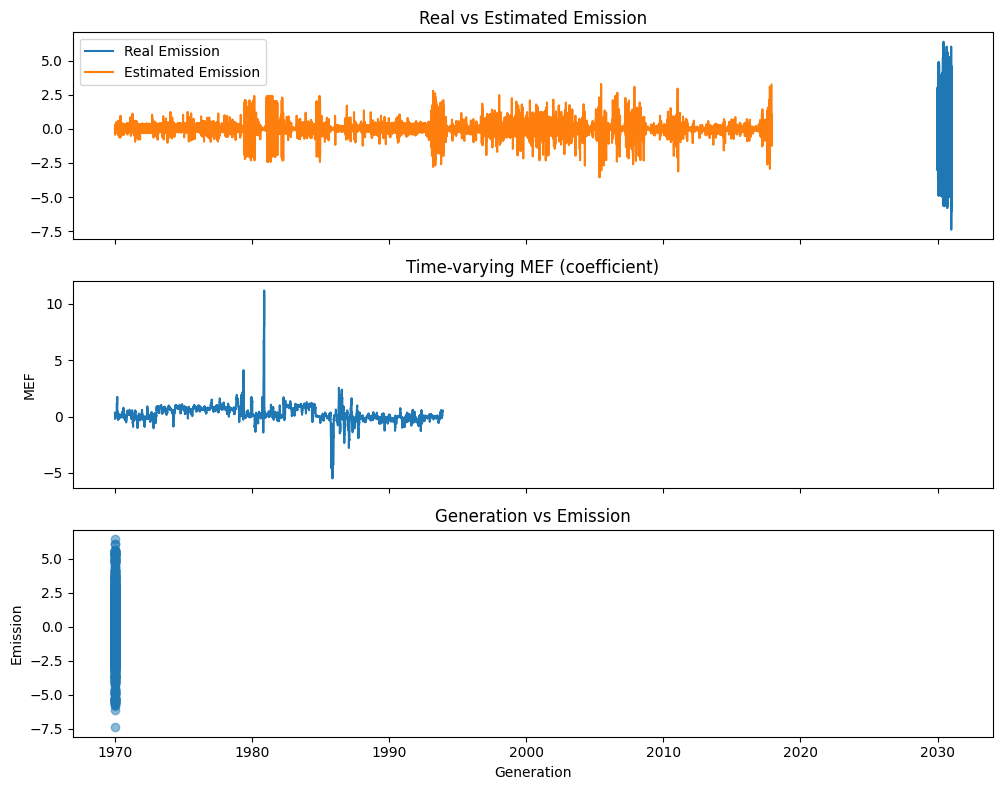

In [ ]:


# Function to perform rolling linear regression
def rolling_regression(ret, window_size):
    results = []
    for i in range(len(ret) - window_size + 1):
        window = ret.iloc[i:i+window_size]
        X = sm.add_constant(window['Generation'])
        y = window['Emissions']
        model = sm.OLS(y, X).fit()
        results.append(model.params['Generation'])
    return results

# Rolling window size
window_size = 24

# Perform rolling linear regression
rolling_coef = rolling_regression(ret, window_size)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting Emission
ax[0].plot(ret['Emissions'], label='Real Emission')
ax[0].set_title('Real vs Estimated Emission')
ax[0].legend()

# Plotting estimated Emission
estimated_emission = ret['Generation'] * rolling_coef[0]
for i in range(1, len(rolling_coef)):
    estimated_emission = np.concatenate((estimated_emission, ret['Generation'].iloc[i:i+1] * rolling_coef[i]))
ax[0].plot(estimated_emission, label='Estimated Emission')
ax[0].legend()

# Plotting MEF (time-varying coefficient)
ax[1].plot(rolling_coef)
ax[1].set_title('Time-varying MEF (coefficient)')
ax[1].set_ylabel('MEF')

# Plotting scatter plot of Generation vs Emission
ax[2].scatter(ret['Generation'], ret['Emissions'], alpha=0.5)
ax[2].set_title('Generation vs Emission')
ax[2].set_xlabel('Generation')
ax[2].set_ylabel('Emission')

plt.tight_layout()
plt.show()


In [ ]:
#eliminate this if not first diff time series
#dret = dret[1:]

In [ ]:
X = ret[ret.columns[1]]
Y = ret[ret.columns[0]]
print("In our regression Y is {} and X is {}".format(ret.columns[0],ret.columns[1]) )

In our regression Y is Emissions and X is Generation


In [ ]:
print(Y)

Date
2030-01-01 00:00:00    0.000319
2030-01-01 01:00:00   -0.811119
2030-01-01 02:00:00   -1.081599
2030-01-01 03:00:00    0.856837
2030-01-01 04:00:00    0.000319
                         ...   
2030-12-31 19:00:00    2.705113
2030-12-31 20:00:00   -2.704475
2030-12-31 21:00:00    1.803515
2030-12-31 22:00:00   -1.802877
2030-12-31 23:00:00   -1.487318
Name: Emissions, Length: 8759, dtype: float64


In [ ]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2)
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS,
                                                                             alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 0.124614, alpha: -0.000000, R2: 0.015529, standard error: 0.010603.

Or I can estimate by myself:
beta: 0.12461362851067641, alpha: -9.636342947211564e-18, sigma: 0.992318641243787


In [ ]:
n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)

beta: 0.12461362851067634 and alpha: -9.636342947211564e-18
sigma: 0.9923186412437868
Standard Error for beta:  0.01060288098850016
R squared: 0.015528556410596856
Confidence intervals for beta:  (0.10382949093018222, 0.14539776609117044)
Confidence intervals for alpha:  (-0.020784137580494123, 0.020784137580494102)


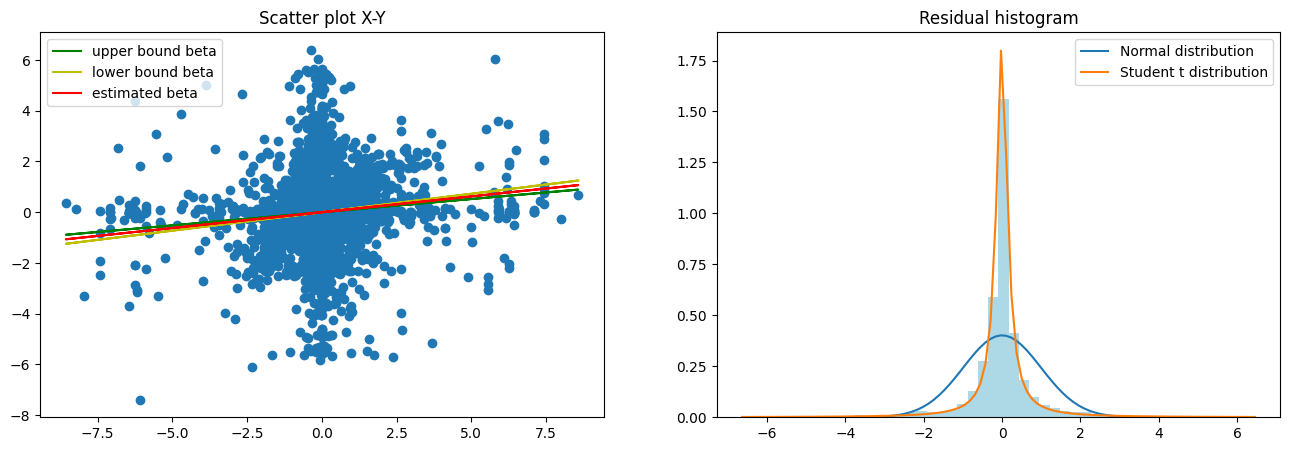

In [ ]:
x = np.linspace(res.min(),res.max(),100)     # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Scatter plot X-Y")
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue")
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()

In [ ]:
#print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  0.9628719240557728




# **The Kalman filter**

In [ ]:
Y = ret.columns[0]
X = ret.columns[1]
training_size = 8000
ret_train = ret.iloc[:training_size]
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of")
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols)
total_length = len(ret)
training_size = total_length - 8711

ret_test = ret.iloc[training_size:]

rolling_window = 48
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = df.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

import numpy as np
from sklearn.linear_model import LinearRegression

# your time series data
data = ret
endog=data["Generation"].values.reshape(1,-1)
exog=data["Emissions"].values.reshape(1,-1)

# fit a simple linear regression model
reg = LinearRegression().fit(endog, exog)

# calculate the residuals from the linear regression model
residuals = endog - reg.predict(endog)

# estimate the initial variance of the residuals
var_eps_ols = np.var(residuals)

# estimate the initial covariance matrix of alpha and beta
P = np.cov(residuals, reg.predict(endog))[0,1]
P = np.array([[var_eps_ols, P], [P, var_eps_ols]])

# estimate the variances of the process noise
eta_alpha = np.var(residuals) / len(residuals)
eta_beta = np.var(reg.predict(endog)) / len(residuals)
Q = np.diag([eta_alpha, eta_beta])

# initialize the other variables for the Kalman filter
x = np.array([[reg.intercept_],[reg.coef_[0]]])        # initial mean of alpha and beta
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim
F = np.eye(2)                               # transition matrix
#H = np.vstack( (np.ones(len(data)), data[:,0]) ).T                 # measurement matrix
print(eta_alpha)
print(eta_beta)
print(P)


x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 0.1 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 0.704                     # variance of the alpha process
eta_beta = 1                          # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T                 # measurement matrix

alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q

    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar.
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product

    alphas[i] = x[0]; betas[i] = x[1]

plt.figure(figsize=(16,6))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()

plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.legend(); plt.title("Comparison Beta"); plt.show()

In [ ]:
Y = ret.columns[0]
X = ret.columns[1]

In [ ]:
print(Y)

Emissions


In [ ]:
training_size = 8000
ret_train = ret.iloc[:training_size]

In [ ]:
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of")
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  0.0003788264772322477
beta_tr =  0.160076777670893
var_eps =  0.958817879482834


In [ ]:
total_length = len(ret)
training_size = total_length - 8711

ret_test = ret.iloc[training_size:]

In [ ]:
training_size

48

In [ ]:
print(ret_train)

                     Emissions  Generation
Date                                      
2030-01-01 00:00:00   0.000319    0.858300
2030-01-01 01:00:00  -0.811119   -1.180099
2030-01-01 02:00:00  -1.081599   -1.320098
2030-01-01 03:00:00   0.856837   -0.072834
2030-01-01 04:00:00   0.000319    0.429407
...                        ...         ...
2030-11-30 03:00:00   0.315878   -0.359050
2030-11-30 04:00:00   0.586358   -0.793442
2030-11-30 05:00:00   0.360958    0.698362
2030-11-30 06:00:00  -0.044761   -0.440571
2030-11-30 07:00:00   0.090479    1.221822

[8000 rows x 2 columns]


**Rolling alpha and beta**

Here I calculate the OLS α and  β  in the test set, using a rolling window.

In [ ]:
rolling_window = 48
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = df.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

**Implementation of the Kalman filter for α and beta**

initial values estimating

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# your time series data
data = ret
endog=data["Generation"].values.reshape(1,-1)
exog=data["Emissions"].values.reshape(1,-1)

# fit a simple linear regression model
reg = LinearRegression().fit(endog, exog)

# calculate the residuals from the linear regression model
residuals = endog - reg.predict(endog)

# estimate the initial variance of the residuals
var_eps_ols = np.var(residuals)

# estimate the initial covariance matrix of alpha and beta
P = np.cov(residuals, reg.predict(endog))[0,1]
P = np.array([[var_eps_ols, P], [P, var_eps_ols]])

# estimate the variances of the process noise
eta_alpha = np.var(residuals) / len(residuals)
eta_beta = np.var(reg.predict(endog)) / len(residuals)
Q = np.diag([eta_alpha, eta_beta])

# initialize the other variables for the Kalman filter
x = np.array([[reg.intercept_],[reg.coef_[0]]])        # initial mean of alpha and beta
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim
F = np.eye(2)                               # transition matrix
#H = np.vstack( (np.ones(len(data)), data[:,0]) ).T                 # measurement matrix
print(eta_alpha)
print(eta_beta)
print(P)


1.7507727429786475
0.9999999999999998
[[ 1.75077274 -0.87548632]
 [-0.87548632  1.75077274]]


In [ ]:
x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 0.1 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 0.704                     # variance of the alpha process
eta_beta = 1                          # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T                 # measurement matrix

In [ ]:
alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q

    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar.
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product

    alphas[i] = x[0]; betas[i] = x[1]

<ipython-input-29-d3de67e19ce8>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alphas[i] = x[0]; betas[i] = x[1]


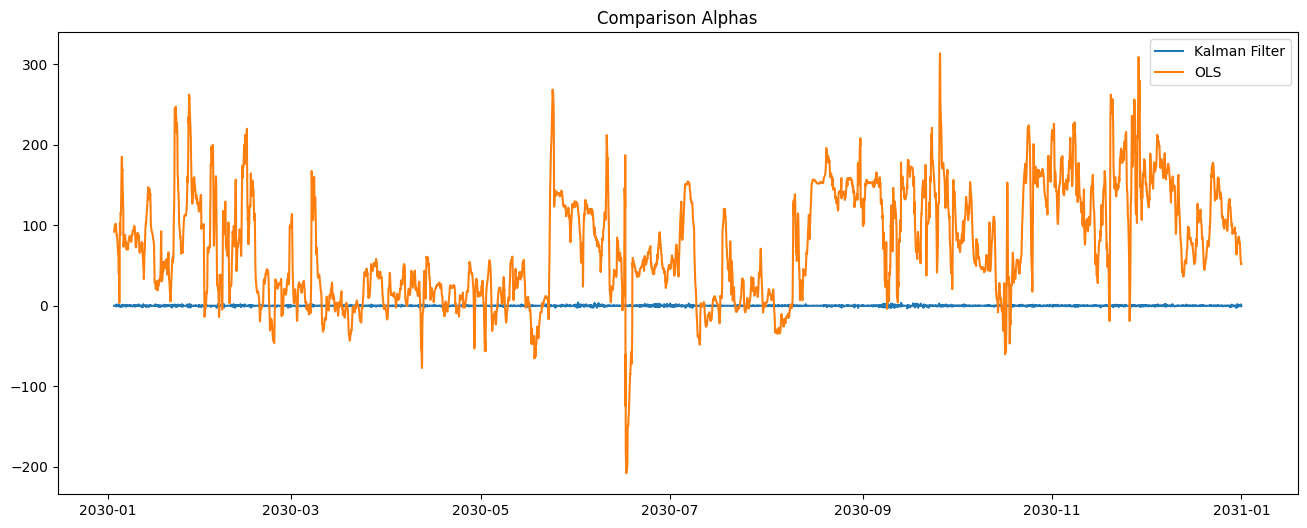

In [ ]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()

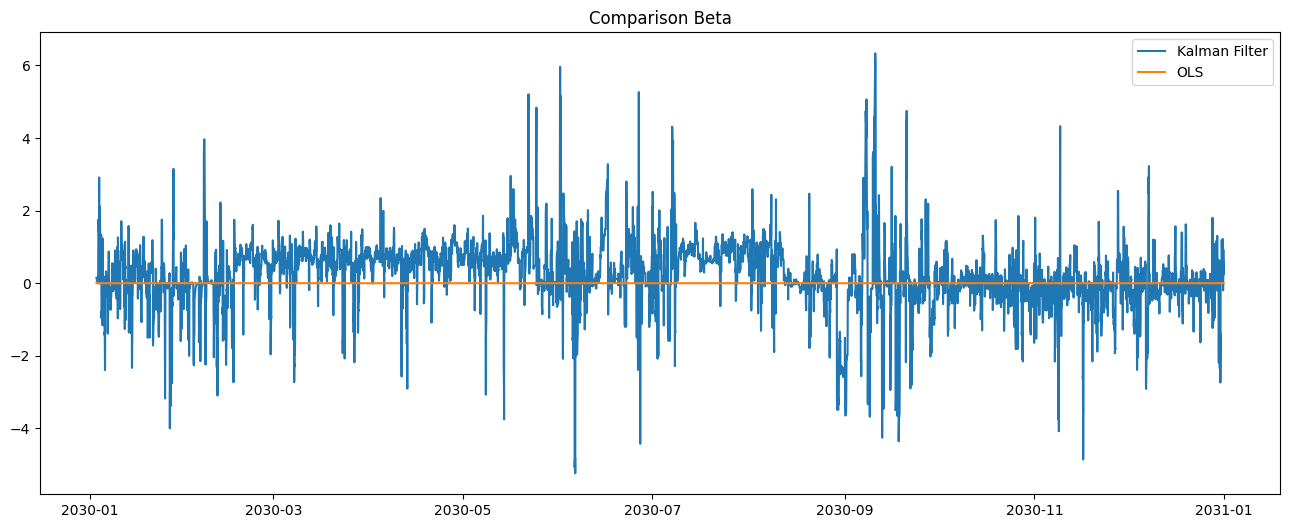

In [ ]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.legend(); plt.title("Comparison Beta"); plt.show()

In [ ]:
ret_test["ols_beta"]

Date
2030-01-03 00:00:00    1.204662e-06
2030-01-03 01:00:00    1.092771e-06
2030-01-03 02:00:00    9.582671e-07
2030-01-03 03:00:00    8.773831e-07
2030-01-03 04:00:00    7.948391e-07
                           ...     
2030-12-31 19:00:00    3.226898e-06
2030-12-31 20:00:00    3.322261e-06
2030-12-31 21:00:00    3.357630e-06
2030-12-31 22:00:00    3.332190e-06
2030-12-31 23:00:00    3.313591e-06
Name: ols_beta, Length: 8711, dtype: float64

In [ ]:
import pandas as pd

beta_kalman = pd.Series(betas, index=ret_test.index)
print(beta_kalman)

Date
2030-01-03 00:00:00    0.147908
2030-01-03 01:00:00    0.133514
2030-01-03 02:00:00    0.126025
2030-01-03 03:00:00    0.070499
2030-01-03 04:00:00    0.070417
                         ...   
2030-12-31 19:00:00    0.251312
2030-12-31 20:00:00    0.919993
2030-12-31 21:00:00    0.235251
2030-12-31 22:00:00    0.447248
2030-12-31 23:00:00    0.578340
Length: 8711, dtype: float64


In [ ]:
# Step 2: Check for negative values in the time series and convert them to zero
num_neg_values = (beta_kalman < 0).sum()
beta_kalman[beta_kalman < 0] = 0

# Step 3: Display the results
print(f"Negative values in beta_kalman: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")


Negative values in beta_kalman: Yes
Number of negative values converted to zero: 3105


In [ ]:
mean=np.mean(beta_kalman)
mean

0.4290403697784925

In [ ]:
beta_ols=ret_test["ols_beta"]

In [ ]:
meanols=np.mean(beta_ols)
meanols

2.1727768880276626e-06

In [ ]:
# Step 2: Check for negative values in the time series and convert them to zero
num_neg_values = (beta_ols < 0).sum()
beta_kalman[beta_ols < 0] = 0
# Step 3: Display the results
print(f"Negative values in beta_kalman: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")


Negative values in beta_kalman: Yes
Number of negative values converted to zero: 2869


Calculate R2 for each regression

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Define the input data (x) and the actual output data (y)
x = np.array(ret_test[X])
y = np.array(ret_test[Y])
beta_ols=np.array(beta_ols)
beta_kalman=np.array(beta_kalman)

# Calculate the predictions for each regression
y_pred_ols = beta_ols * x
y_pred_kalman = beta_kalman * x

# Calculate the R^2 for each regression
r2_simple = r2_score(y, y_pred_ols)
r2_kalman = r2_score(y, y_pred_kalman)

# Print the R^2 values
print("R^2 for simple regression:", r2_simple)
print("R^2 for Kalman filter regression:", r2_kalman)


R^2 for simple regression: 1.3681929624809186e-06
R^2 for Kalman filter regression: 0.1471806808469608


In [ ]:
# Calculate the MSE
mse_ols = np.mean((y - y_pred_ols) ** 2)
mse_kalman = np.mean((y - y_pred_kalman) ** 2)
# Print the MSE
print("MSE for simple regression:", mse_ols)
print("MSE for Kalman filter regression:", mse_kalman)

MSE for simple regression: 1.0026114996916191
MSE for Kalman filter regression: 0.8550476264121593


In [ ]:
# Calculate the MAE
mae_ols = np.mean(np.abs(y - y_pred_ols))
mae_kalman = np.mean(np.abs(y - y_pred_kalman))

# Calculate the RMSE
rmse_ols = np.sqrt(np.mean((y - y_pred_ols) ** 2))
rmse_kalman = np.sqrt(np.mean((y - y_pred_kalman) ** 2))

# Print the MAE and RMSE
print("MAE for simple regression:", mae_ols)
print("MAE for Kalman filter regression:", mae_kalman)
print("RMSE for simple regression:", rmse_ols)
print("RMSE for Kalman filter regression:", rmse_kalman)


MAE for simple regression: 0.5081451182405625
MAE for Kalman filter regression: 0.4352611259095467
RMSE for simple regression: 1.0013048984658066
RMSE for Kalman filter regression: 0.924687853500931


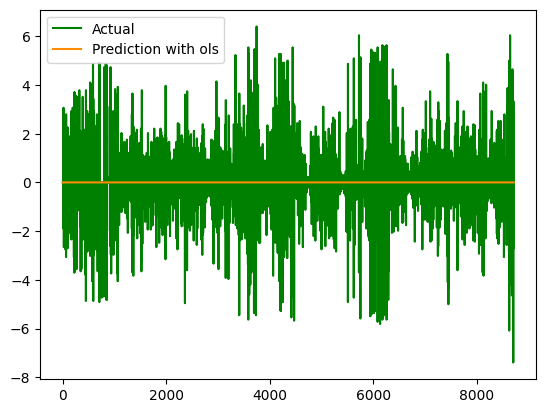

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the actual data (y) and the predictions (y_pred)

# Plot the actual data and predictions
plt.plot(y, label='Actual', color="green")
plt.plot(y_pred_ols, label='Prediction with ols', color='#FF8C00')
#plt.plot(y_pred_kalman, label='Prediction with kalman')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

# Create a DataFrame to store the data
data = pd.DataFrame({
    'Actual': y,
    'Prediction_ols': y_pred_ols,
    # 'Prediction_ols': y_pred_ols  # Uncomment this if you have Kalman predictions
})

# Set the file path
file_path = "predictions_ols.xlsx"  # Replace with the desired file path

# Save the DataFrame to Excel
data.to_excel(file_path, index=False)


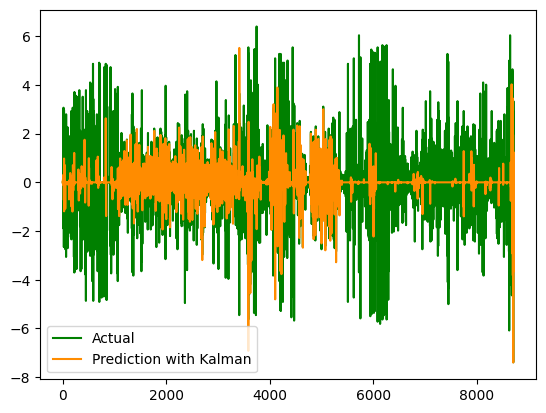

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the actual data and predictions
plt.plot(y, label='Actual', color="green")
plt.plot(y_pred_kalman, label='Prediction with Kalman', color='#FF8C00')
# plt.plot(y_pred_kalman, label='Prediction with Kalman')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

# Create a DataFrame to store the data
data = pd.DataFrame({
    'Actual': y,
    'Prediction_kalman': y_pred_kalman,
    # 'Prediction_Kalman': y_pred_kalman  # Uncomment this if you have Kalman predictions
})

# Set the file path
file_path = "predictions_kal.xlsx"  # Replace with the desired file path

# Save the DataFrame to Excel
data.to_excel(file_path, index=False)


save linear reg and kalman results

In [ ]:
beta_kalman=pd.DataFrame(beta_kalman)
beta_kalman.to_excel('beta_kalman.xlsx', index=False)

In [ ]:
beta_ols=pd.DataFrame(beta_ols)
beta_ols.to_excel('beta_ols.xlsx', index=False)

# **LSTAR MODEL**

In [ ]:
import numpy as np
from joblib import Parallel, delayed
from scipy.optimize import least_squares

def transition_function(s_t, gamma, c):
    return 1 / (1 + np.exp(-gamma * (s_t - c)))

def STR(x, phi0, phi1, phi2, theta0, theta1, theta2, gamma, c):
    x_t = x[:, 0]
    s_t = x[:, 1]
    G = transition_function(s_t, gamma, c)
    y_hat = phi0 + phi1 * x_t + phi2 * s_t + (theta0 + theta1 * x_t + theta2 * s_t) * G
    return y_hat

# y is a 1D array containing the values of y
y = ret['Emission']
x = ret[['Generation without Renewbles', 'Electricity price ']].to_numpy()

# specify the window size
window_size = 24

# generate indices for the rolling window
indices = [(i-window_size, i) for i in range(window_size, len(y))]

# initial guesses for the parameters
phi0_0, phi1_0, phi2_0 = -237.00540, 0.5416, 447.98395
theta0_0, theta1_0, theta2_0 = 601.20749, 0.91319, -422.49485
gamma_0, c_0 = 0.50000, -6.41804
p0 = np.array([phi0_0, phi1_0, phi2_0, theta0_0, theta1_0, theta2_0, gamma_0, c_0])
bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, -np.inf],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# estimate the parameters using nonlinear least squares for each rolling window in parallel
n_jobs = -1  # use all available cores
results = Parallel(n_jobs=n_jobs)(
    delayed(least_squares)(lambda p: STR(x[i:j], *p) - y[i:j], p0, method='trf', bounds=bounds)
    for i, j in indices
)
coefficients = np.array([res.x for res in results])

# extract the time-varying coefficients
phi0_t = coefficients[:, 0]
phi1_t = coefficients[:, 1]
phi2_t = coefficients[:, 2]
theta0_t = coefficients[:, 3]
theta1_t = coefficients[:, 4]
theta2_t = coefficients[:, 5]
gamma_t = coefficients[:, 6]
c_t = coefficients[:, 7]

KeyError: 'Emission'

In [ ]:
# create a DataFrame containing the coefficients and the time series of the transition function
data = pd.DataFrame({
    'phi0_t': phi0_t,
    'phi1_t': phi1_t,
    'phi2_t': phi2_t,
    'theta0_t': theta0_t,
    'theta1_t': theta1_t,
    'theta2_t': theta2_t,
    'gamma_t': gamma_t,
    'c_t': c_t,
})

# save the DataFrame to an Excel file
data.to_excel('coefficients.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt

# plot phi0_t
plt.plot(phi0_t)
plt.xlabel('Time')
plt.ylabel('phi0_t')
plt.show()

# plot phi1_t
plt.plot(phi1_t)
plt.xlabel('Time')
plt.ylabel('phi1_t')
plt.show()

# plot phi2_t
plt.plot(phi2_t)
plt.xlabel('Time')
plt.ylabel('phi2_t')
plt.show()

# plot theta0_t
plt.plot(theta0_t)
plt.xlabel('Time')
plt.ylabel('theta0_t')
plt.show()

# plot theta1_t
plt.plot(theta1_t)
plt.xlabel('Time')
plt.ylabel('theta1_t')
plt.show()

# plot theta2_t
plt.plot(theta2_t)
plt.xlabel('Time')
plt.ylabel('theta2_t')
plt.show()

# plot gamma_t
plt.plot(gamma_t)
plt.xlabel('Time')
plt.ylabel('gamma_t')
plt.show()

# plot c_t
plt.plot(c_t)
plt.xlabel('Time')
plt.ylabel('c_t')
plt.show()

# plot the time series of the transition function
#plt.plot(transition_function(x[:, 1], gamma_t, c_t))
#plt.xlabel('Time')
#plt.ylabel('Transition function')
#plt.show()

In [ ]:
import numpy as np

# assume that phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t, c_t are arrays of shape (N,)
avg_phi0 = np.mean(phi0_t)
avg_phi1 = np.mean(phi1_t)
avg_phi2 = np.mean(phi2_t)
avg_theta0 = np.mean(theta0_t)
avg_theta1 = np.mean(theta1_t)
avg_theta2 = np.mean(theta2_t)
avg_gamma = np.mean(gamma_t)
avg_c = np.mean(c_t)

# print the averages
print("Average phi0:", avg_phi0)
print("Average phi1:", avg_phi1)
print("Average phi2:", avg_phi2)
print("Average theta0:", avg_theta0)
print("Average theta1:", avg_theta1)
print("Average theta2:", avg_theta2)
print("Average gamma:", avg_gamma)
print("Average c:", avg_c)

Average phi0: -48555.43711231495
Average phi1: -58.3771601697057
Average phi2: -2697.118801317898
Average theta0: 1054801.6571251315
Average theta1: 537.1142769754706
Average theta2: -129605.82495671137
Average gamma: 31.77064992972649
Average c: -9.956158510066995


In [ ]:
# calculate the predicted values of y
y_pred = STR(x[24:], phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t, c_t)
# calculate the mean of y
y_mean = np.mean(y[24:])

# calculate the sum of squared errors
SSE = np.sum((y[24:] - y_pred)**2)

# calculate the total sum of squares
SST = np.sum((y[24:] - y_mean)**2)

# calculate the R-squared
R2 = 1 - SSE/SST

print("R-squared:", R2)

R-squared: 0.6751031744100513


<ipython-input-47-7e8d620249c1>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-gamma * (s_t - c)))


In [ ]:
# predict the values using the model
y_pred = STR(x[24:], *coefficients[-1])

# calculate the evaluation metrics
mae = np.mean(np.abs(y[24:] - y_pred))
mse = np.mean((y[24:] - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y[24:] - y_pred)/y[24:])) * 100

# calculate Theil's U-statistic
naive = np.roll(y[24:], -1)
u_stat = np.sqrt(np.mean((y[24:] - y_pred)**2)/np.mean((y[24:] - naive)**2))

# print the results
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)
print("Theil's U-statistic:", u_stat)

MAE: 988.8556723438837
MSE: 1978669.235506937
RMSE: 1406.6517818944876
MAPE: inf
Theil's U-statistic: 0.7118181827332872


In [ ]:
sse = np.sum((y[24:] - y_pred)**2)
## compute the number of parameters
k = len(coefficients.T)

# compute the number of observations
n = len(y[24:])

# compute the BIC and AIC
bic = n * np.log(sse/n) + k * np.log(n)
aic = n * np.log(sse/n) + 2 * k

print("BIC:", bic)
print("AIC:", aic)

BIC: 117998.23435196104
AIC: 117942.20388726931


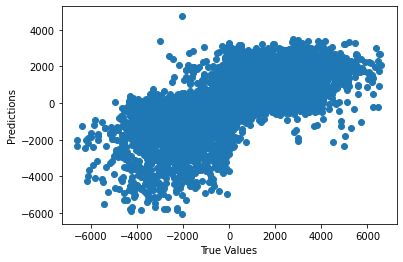

In [ ]:
import matplotlib.pyplot as plt

# plot y_pred vs y
plt.scatter(y[24:], y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


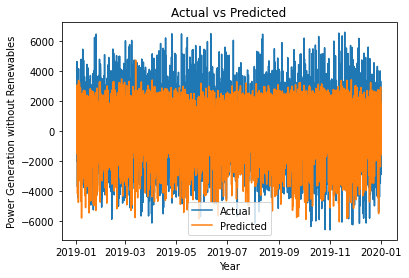

In [ ]:
import matplotlib.pyplot as plt

# plot the time series of y and y_pred
plt.plot(dret.index[window_size:], y[24:], label='Actual')
plt.plot(dret.index[window_size:], y_pred, label='Predicted')

# set the title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Power Generation without Renewables')

# display the legend
plt.legend()

# show the plot
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame for y and y_pred
results = pd.DataFrame({
    'y': y[24:],
    'y_pred': y_pred
})

# Save to an Excel file
results.to_excel('results.xlsx', index=False)

# Create a DataFrame for the coefficients
coefficients_df = pd.DataFrame({
    'phi0_t': phi0_t,
    'phi1_t': phi1_t,
    'phi2_t': phi2_t,
    'theta0_t': theta0_t,
    'theta1_t': theta1_t,
    'theta2_t': theta2_t,
    'gamma_t': gamma_t,
    'c_t': c_t
})

# Save to an Excel file
coefficients_df.to_excel('coefficients.xlsx', index=False)

# Create a DataFrame for the transition function
s_t = np.arange(-10, 10, 0.1) # set the range of s_t values to plot
G = transition_function(s_t, gamma_t[-1], c_t[-1]) # use the final gamma and c values from the model
transition_df = pd.DataFrame({
    's_t': s_t,
    'G': G
})

# Save to an Excel file
transition_df.to_excel('transition_function.xlsx', index=False)

**compare MEFs to the Benchmark**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the Excel file
df = pd.read_excel('/content/MEF_comparaison.xlsx')

# Get the actual values from column 2
actual_values = df.iloc[:, 1]

# Get the forecast values from columns 3 to 7
forecast_columns = df.columns[2:7]
metrics = {}

for column in forecast_columns:
    forecast_values = df[column]

    # Compute MSE
    mse_value = mean_squared_error(actual_values, forecast_values)

    # Compute RMSE
    rmse_value = np.sqrt(mse_value)

    # Compute MAE
    mae_value = mean_absolute_error(actual_values, forecast_values)

    # Compute MAPE
    mape_value = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100

    metrics[column] = {
        'MSE': mse_value,
        'RMSE': rmse_value,
        'MAE': mae_value,
        'MAPE': mape_value
    }

# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame(metrics).T




In [ ]:
metrics_df

,MSE,RMSE,MAE,MAPE
MEF_OLS,0.177099,0.420831,0.382355,inf
MEF -KALMAN,0.488906,0.699218,0.539623,inf
phi1,0.207983,0.456051,0.399541,inf
theta1,0.093822,0.306304,0.243894,inf
STR,0.309209,0.556066,0.485980,inf


In [ ]:
# Save the metrics DataFrame as an Excel file
metrics_df.to_excel('/content/MEF_comparaison_results')

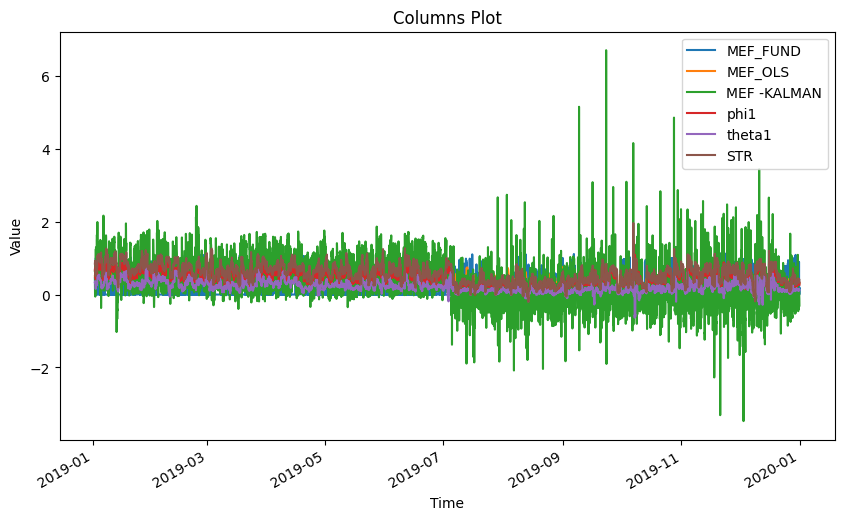

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel('/content/MEF_comparaison.xlsx')

# Set the first column as the index (assuming it contains the date)
df.set_index(df.columns[0], inplace=True)

# Plot all columns
df.plot(figsize=(10, 6))

# Set plot title and labels
plt.title('Columns Plot')
plt.xlabel('Time')
plt.ylabel('Value')

# Show the plot
plt.show()


In [ ]:
df

,MEF_FUND,MEF_OLS,MEF -KALMAN,phi1,theta1,STR
Date,,,,,,
2019-01-02 00:59:59.983,0.451524,0.500748,0.652185,0.684823,0.337405,0.851605
2019-01-02 01:59:59.983,0.000000,0.484305,0.662955,0.701063,0.345033,0.872619
2019-01-02 02:59:59.983,0.000000,0.489528,0.696354,0.700721,0.344798,0.870719
2019-01-02 03:59:59.983,0.000000,0.478375,0.797724,0.744711,0.369623,0.930547
2019-01-02 04:59:59.983,0.451524,0.480883,0.922295,0.718599,0.356503,0.898639
...,...,...,...,...,...,...
2019-12-31 18:59:59.982,0.164037,0.342092,0.090319,0.325911,0.139260,0.394510
2019-12-31 19:59:59.982,0.182400,0.332126,0.044188,0.349342,0.148873,0.422229
2019-12-31 20:59:59.982,0.180165,0.326483,-0.026938,0.331253,0.141504,0.401128


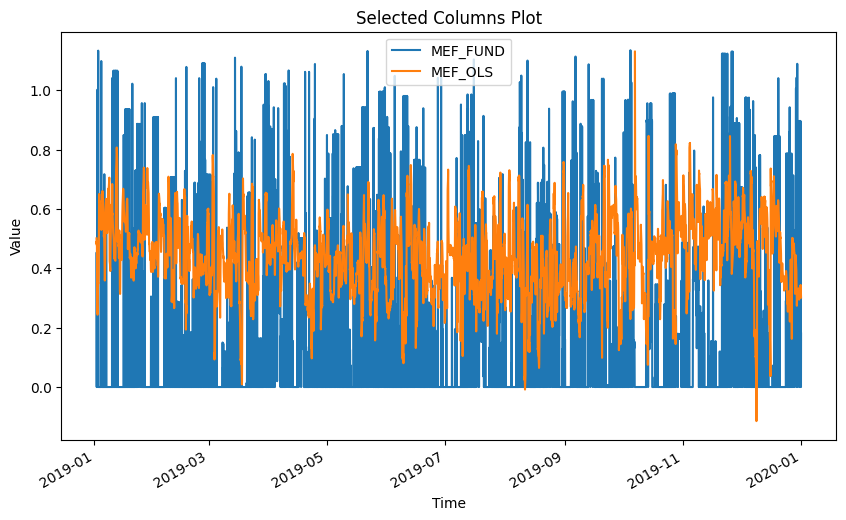

In [ ]:
# Select the columns to plot by name
columns_to_plot = ['MEF_FUND', 'MEF_OLS', 'MEF -KALMAN', 'theta1']

# Plot selected columns
df[columns_to_plot].plot(figsize=(10, 6))

# Set plot title and labels
plt.title('Selected Columns Plot')
plt.xlabel('Time')
plt.ylabel('Value')

# Show the plot
plt.show()

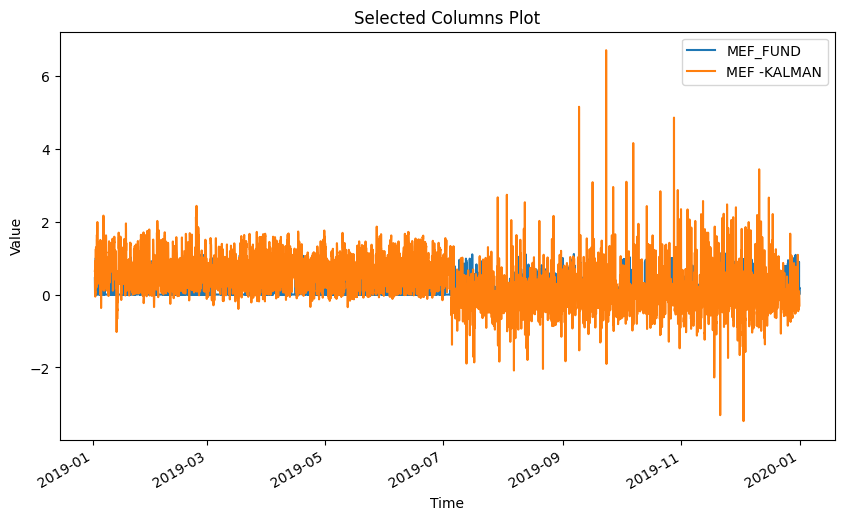

In [ ]:
# Select the columns to plot by name
columns_to_plot = ['MEF_FUND','MEF -KALMAN']

# Plot selected columns
df[columns_to_plot].plot(figsize=(10, 6))

# Set plot title and labels
plt.title('Selected Columns Plot')
plt.xlabel('Time')
plt.ylabel('Value')

# Show the plot
plt.show()

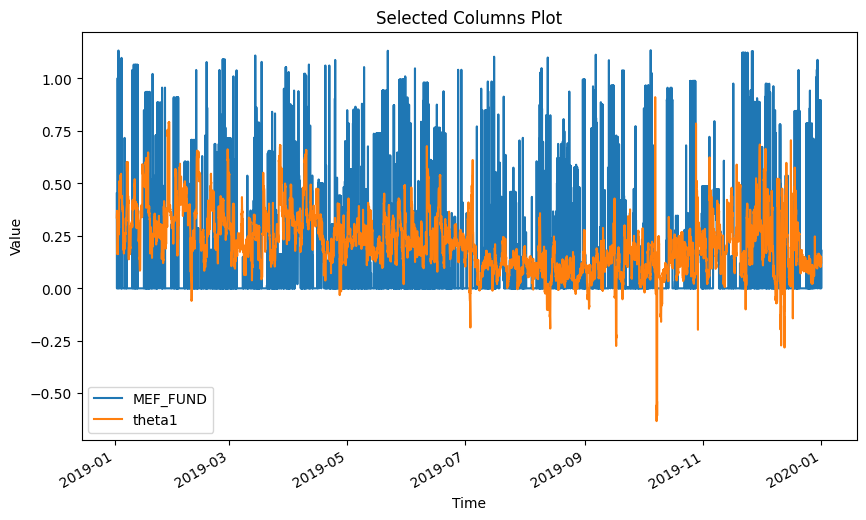

In [ ]:
# Select the columns to plot by name
columns_to_plot = ['MEF_FUND', 'theta1']

# Plot selected columns
df[columns_to_plot].plot(figsize=(10, 6))

# Set plot title and labels
plt.title('Selected Columns Plot')
plt.xlabel('Time')
plt.ylabel('Value')

# Show the plot
plt.show()